# Pneumonia X-ray Image Classification

### Overview

This project analyses over 5,800 chest x-ray images taken of pediatric patients both with and without pneumoina and develops a binary classifcation model to predict pneumonia status. The JPEG images were selected from groups of pediatric parients ages one to five years old from Guangzhou Women and Children's Medical Center, Guangzhou China. The World Health Organization(WHO) is requesting a model to help accurately predict pneumonia in young patients.

### Business Problem

Pneumonia is the single largest infectious cause of death in children worldwide and results in 22% of all deaths in children aged 1 to 5. Early identification and intervention is key in preventing young deaths. WHO will use the model to help identify the early stages of pneumonia in children. When building the model, careful consideration was taken to identify and remedy false negatives-pneumonia cases that are incorrectly labeled as normal.

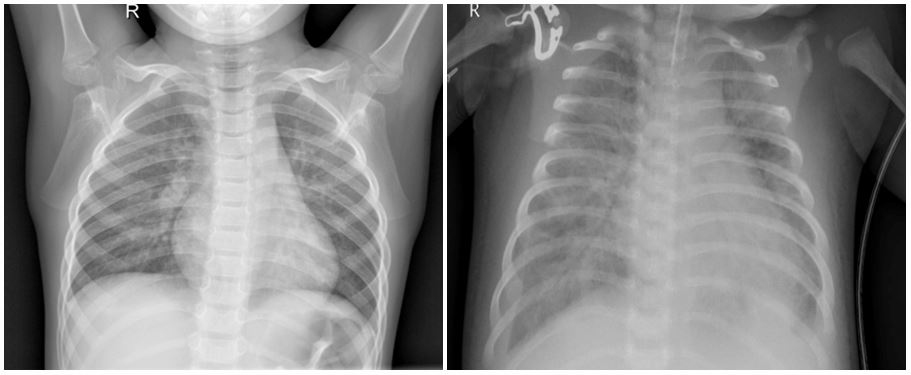

In [51]:
#Importing the relevant libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, LSTM, AveragePooling2D
from keras.datasets import mnist
from keras import regularizers, initializers, optimizers
import os
import datetime
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path
import imagesize
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
import seaborn as sns
from utils import images_to_df, pic_count, visualize_training_results, plot_performance
from utils20 import matrix_confusion
from utils3 import eda_plotly
import gc
from timeit import default_timer as timer
import tensorflow as tf
pd.set_option('display.float_format', lambda x: '%.1f' % x)
os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict
from tensorflow.keras.preprocessing import image

In [2]:
#Bringing in the data

train_folder = 'data/chest_xray/train/'
holdout_folder = 'data/chest_xray/val/'
test_folder = 'data/chest_xray/test/'

### Data Understanding

Our images were sourced from Chest X-rays provided by [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2). Our dataset uses over 5800 images of pediatric patients ages one to five from Guangzhou Women and Children's Medical Center. The images were taken as part of the patients routine care. The images were analysed by two expert physicians before being clearned for use in training the AI system and  third expert validated the analysis. 



When first evaluating our data, we see that the validation set only holds 16 images. This is a very small percentage of the number of images avalailable and it does not provide much use as a validation set. To address this, we will create a separate validation set later by splitting our test set into a test and validation set. 


In [3]:
#Function to take counts of normal and pneumonia images in each folder and return them as bar graphs

pic_count(holdout_folder, 'Holdout Images')
pic_count(train_folder, 'Training Images')
pic_count(test_folder, 'Test Images')


From the graphs, we can see our image count is very imbalanced. There are many more 'Pneumonia' images than 'Normal' images. To address this, it would be ideal to increase the number of samples in the 'Normal' class by transforming the images. This will be a technique we will dive into in future iterations of the model.  

We now move to analyzing the average amount of pixels in our images to get an idea of the ideal image size when reshaping and scaling.  

In [4]:
root = 'data/chest_xray/train/NORMAL/'
root1= 'data/chest_xray/train/PNEUMONIA/'

In [5]:
#Custom function returns a concatenated DataFrame containing columns for:
#FileName, Size, Width, Aspect Ratio, and Image Type.
images_to_df(root, root1, 'Normal', 'Pneumonia' )

FileName          Size  Width  Height  Aspect Ratio  \
0            IM-0115-0001.jpeg  (2090, 1858)   2090    1858           1.1   
1            IM-0117-0001.jpeg  (1422, 1152)   1422    1152           1.2   
2            IM-0119-0001.jpeg  (1810, 1434)   1810    1434           1.3   
3            IM-0122-0001.jpeg  (1618, 1279)   1618    1279           1.3   
4            IM-0125-0001.jpeg  (1600, 1125)   1600    1125           1.4   
...                        ...           ...    ...     ...           ...   
3870   person99_virus_183.jpeg   (1414, 882)   1414     882           1.6   
3871  person9_bacteria_38.jpeg   (1256, 696)   1256     696           1.8   
3872  person9_bacteria_39.jpeg   (1152, 856)   1152     856           1.4   
3873  person9_bacteria_40.jpeg   (1248, 728)   1248     728           1.7   
3874  person9_bacteria_41.jpeg   (1176, 784)   1176     784           1.5   

           Type  
0        Normal  
1        Normal  
2        Normal  
3        Normal  
4        Normal  
...         ...  
3870  Pneumonia  
3871  Pneumonia  
3872  Pneumonia  
3873  Pneumonia  
3874  Pneumonia  

[5216 rows x 6 columns]

Looking at the breakdown of our dataframe, we can see the spread of the width and heights of the images in our datasets. We can see that the majority of the images are between 1050 and 1550 pixels width, and between 700 and 1150 pixel height. These images are large, and with more computing power we would be able to analyse them at larger sizes. Becuase of our computing limitations, we will have to scale the images down, losing some information as a result. 

In [6]:
total_img_meta_df = images_to_df(root, root1, 'Normal', 'Pneumonia' )
total_img_meta_df.describe()

Width  Height  Aspect Ratio
count 5216.0  5216.0        5216.0
mean  1320.6   968.1           1.4
std    355.3   378.9           0.3
min    384.0   127.0           0.8
25%   1056.0   688.0           1.3
50%   1284.0   888.0           1.4
75%   1552.0  1187.8           1.6
max   2916.0  2663.0           3.4

In [7]:
"""
Custom function 

Returns three Plotly visuals including: 

1. Scatter plot of Height and Width (pixels)
2. Histogram of distrubition Height vs Width, 
3. Histogram of distribution of Width vs Height.
"""

eda_plotly(total_img_meta_df, 'Train Image Sizes', 'Train Image Width', 'Train Image Height')

### Image Insights 

We used a few different techniques to visualize our images and get insights into how our model will differentiate between normal and pneumonia x-rays. 

In [53]:
"""
The code to creatively visualize our images was sourced from Eunjoo Byeon. 
The original information was found on towards data science. 
https://towardsdatascience.com/detecting-pneumonia-using-convolutional-neural-network-599aea2d3fc9

The code was pulled from her github found here:
https://github.com/stereopickle/pneumonia_img_classification
"""

train_dir = 'data/chest_xray/train/'
normal_jpeg = [fn for fn in os.listdir(f'{train_dir}/NORMAL') if 
fn.endswith('.jpeg')]
pneumo_jpeg = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if 
fn.endswith('.jpeg')]

In [54]:
# Changes all images into an array
def image_array(path, list_of_filename, size=(64,64)):
    for f in list_of_filename:
        file_path = path + f
        current_image = image.load_img(file_path, target_size=size, 
color_mode='grayscale')
        image_ts = image.img_to_array(current_image)
        image_ts = [image_ts.ravel()]
        try:
            full_mat = np.concatenate((full_mat, image_ts))
        except UnboundLocalError:
            full_mat = image_ts
    return full_mat
norm_images = image_array(f'{train_dir}/NORMAL/', normal_jpeg)
pneumonia_images = image_array(f'{train_dir}/PNEUMONIA/', pneumo_jpeg)
from sklearn.decomposition import PCA
from math import ceil

The Eigenimages below show all the individual components that are being identified as significant in the respective sets.
The images below are visually describing the pricipal components that show 70% of the variablility for each class.

Number of Principle Components:  28


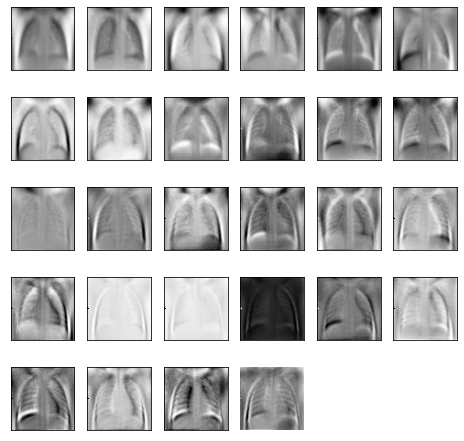

Number of Principle Components:  14


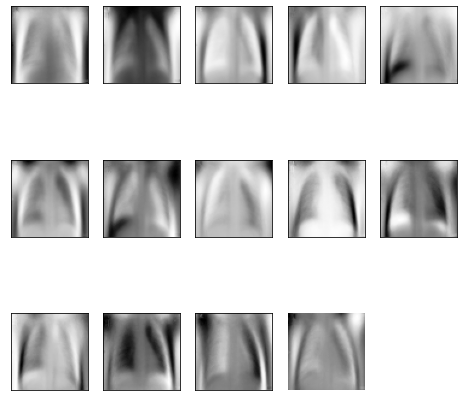

In [55]:
def eigenimages(full_mat, title, ncomp=0.7, size=(64,64)):
    pca = PCA(n_components=ncomp, whiten=True)
    pca.fit(full_mat)
    print('Number of Principle Components: ', pca.n_components_)
    return pca
def plot_pca(pca, size=(64,64)):
    n = pca.n_components_
    fig = plt.figure(figsize=(8,8))
    r = int(n**.5)
    c = ceil(n/r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i+1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(size),
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
plot_pca(eigenimages(norm_images, 'NORMAL'))
plot_pca(eigenimages(pneumonia_images, 'PNEUMONIA'))

In the below images, we are taking the average value for each pixel in our respective datasets and using that information to construct an average normal and pneumonia photo. This gives great insights into the general differences between our normal patients and those with pneumonia. 

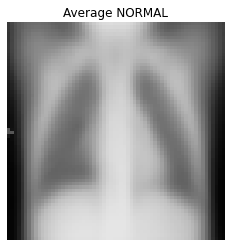

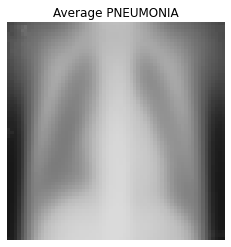

In [56]:
def find_mean_img(full_mat, title, size = (64, 64)):
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img
norm_mean = find_mean_img(norm_images, 'NORMAL')
pneu_mean = find_mean_img(pneumonia_images, 'PNEUMONIA')


### Image Data Pre-processing

We want to start pre-processing our images before putting them through the models. Our pre-processing will ensure all images are the same size and are scaled down to relieve any computational pressure. We also indicate we are working on a binary classification problem by setting class mode to 'binary'. Our test set has shuffle set to False because we don't want to introduce any extra stochasticity. 

In [8]:
#Rescaling our images and pre-processing them using ImageDataGenerator on train and test sets.
train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_folder, batch_size=5232, target_size=(255,255), class_mode = 'binary')

test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_folder, batch_size=624, target_size=(255,255), class_mode = 'binary', shuffle = False)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
#Separating our train and test folders into images and labels

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

0.0


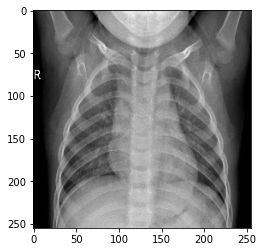

In [10]:
#Photo example
plt.imshow(array_to_img(train_images[0]))
print(train_labels[0])

In [11]:
#Checking the shape of our data to make sure the amount of labels lines up with the images
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5216, 255, 255, 3)
(5216,)
(624, 255, 255, 3)
(624,)


In [12]:
#Casting our images as float 32s
X_train = train_images.astype('float32')
X_test = test_images.astype('float32')

In [13]:
#Verifying the shape of our data
X_train.shape

(5216, 255, 255, 3)

We will create a separate validation set that will be a subset of our test set. This will be data reserved for testing on our final model. We do this prevent data leakage from our training an testing datasets.

In [14]:
#Performing train test split

X_final_test, X_val, y_final_test, y_val = train_test_split(X_test, test_labels, random_state=42, train_size=.2)

### First Simple Model

Now that we have pre-processed and separated our training, test, and validations sets, we can start modeling. 

For our first model, we wanted to start as simply as possible to evaluate performance. 

We start with an Input layer to establish the shape and structure of the incoming data. We are starting with a smaller size than we found is an ideal average for our photos due to processing limitations. We included a flattening layer to put our images into one long array. We then add two simple Dense layers that will funnel our information down. Our final Dense layer uses sigmoid activation because we are working on a binary classification problem.

In [15]:
model = Sequential(
    [
        Input((255,255,3)),
        Flatten(), # need to flatten our images to be one long array
        Dense(64,activation="relu"),
        Dense(1, activation="sigmoid"),  
        
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 195075)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12484864  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,484,929
Trainable params: 12,484,929
Non-trainable params: 0
_________________________________________________________________


When compiling our model, we used binary crossentropy to evaluate loss because of our binary classification problem. Adam was the best optimizer that we found across all models. When then establish our evaluation metrics.

In [16]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', 'Recall', 'Precision'])

In [17]:
batch_size = int(X_train.shape[0]/20)

We are now fitting our model and we set the first number of epochs as 5 to get a quick understanding of our performance.

In [18]:
history = model.fit(train_images, 
                    train_labels, 
                    batch_size=batch_size,
                    epochs=5, 
                    validation_data=(X_val, y_val))

Epoch 1/5
21/21 [==============================] - 7s 318ms/step - loss: 9.9533 - accuracy: 0.7195 - recall: 0.8299 - precision: 0.8000 - val_loss: 1.9934 - val_accuracy: 0.8320 - val_recall: 0.8818 - val_precision: 0.8545
Epoch 2/5
21/21 [==============================] - 5s 251ms/step - loss: 1.8263 - accuracy: 0.8817 - recall: 0.9221 - precision: 0.9190 - val_loss: 3.9638 - val_accuracy: 0.7600 - val_recall: 0.9840 - val_precision: 0.7281
Epoch 3/5
21/21 [==============================] - 5s 240ms/step - loss: 0.9288 - accuracy: 0.9178 - recall: 0.9468 - precision: 0.9427 - val_loss: 4.7152 - val_accuracy: 0.7340 - val_recall: 0.9872 - val_precision: 0.7055
Epoch 4/5
21/21 [==============================] - 6s 267ms/step - loss: 0.5013 - accuracy: 0.9410 - recall: 0.9646 - precision: 0.9563 - val_loss: 1.3721 - val_accuracy: 0.8320 - val_recall: 0.9233 - val_precision: 0.8281
Epoch 5/5
21/21 [==============================] - 5s 246ms/step - loss: 0.4205 - accuracy: 0.9433 - recall:

Test loss: 3.367826223373413
Test accuracy: 0.7319999933242798
Test recall: 0.9840255379676819
Test precision: 0.7048054933547974


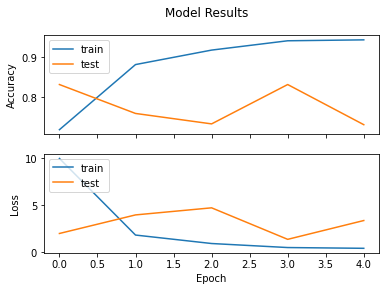

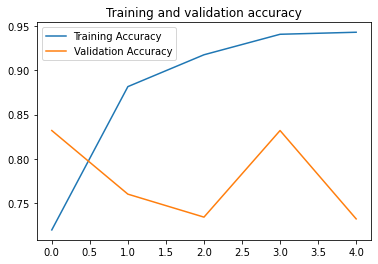

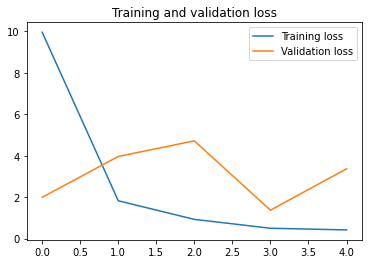

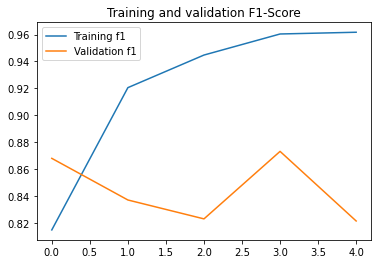

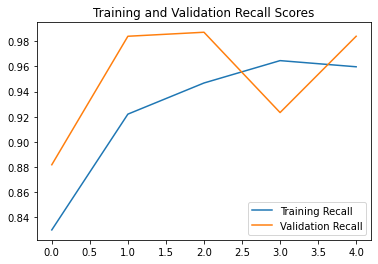

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

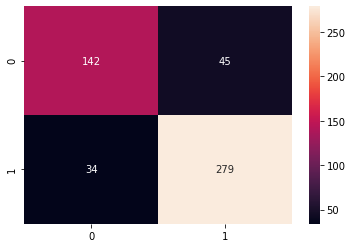

In [38]:
score1 = model.evaluate(X_val, y_val, verbose=0)
print("Test loss:", score1[0])
print("Test accuracy:", score1[1])
print("Test recall:", score1[2])
print("Test precision:", score1[3])
visualize_training_results(history)
plot_performance(history)
matrix_confusion(model, X_val, y_val)

### First Simple Model Evaluation

Our first simple model has a test accuracy of 84%. Our Test recall is 90%. This is a great start for our model as we need to prioritize recall above everything else. Our model is quite overfit and we will need to take steps to address this as we move forward with more models. 

## Model Iterations

In model two, we wanted to play around with diferent types of layers to see their effects. 

Our first layer is a Conv2D layer using the relu activation function. Relu is useful over tanh and sigmoid in the topmost layers because it makes the model easier to train and often the model achieves better performance. Setting 'same' to padding extends the area at which CNN processes an image. We also make sure to set our input shape. Our initial filter is set in this layer which determines the number of filters from which the CNN will learn.

We then include a MaxPooling2D layer. This operation is putting a 2D filter over each channel and summarising the features covered by the filter. This is performing downsampling on our photos, specifically on the height and width of the spatial dimensions. 

We then flatten our matrix down to a single long array before putting it through two more Dense layers. 

We have put in an early stop in this model that should help with some overfitting that we see in our original model. Early stop will make sure to stop the model learning at a point where it seems there are no more improvements to be made on model function.

### Model 2

In [20]:
model2 = Sequential([

        Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (255,255,3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation = 'relu'),
        Dense(1, activation='sigmoid')

]
)


# compiling models
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               66064512  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 66,065,537
Trainable params: 66,065,537
Non-trainable params: 0
_________________________________________________________________


After setting up our model, we can move to our fitting parameters. We chose a larger amount of epochs to give our model more time to learn and to see if we are making improvements on overfitting.

In [21]:
# training
start = timer()

history2 = model2.fit(train_images,
                    train_labels,
                    epochs=20, 
                    validation_data =(X_val,y_val),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/20
163/163 [==============================] - 132s 807ms/step - loss: 0.7010 - accuracy: 0.7997 - recall: 0.9270 - precision: 0.8250 - val_loss: 0.3470 - val_accuracy: 0.8800 - val_recall: 0.8722 - val_precision: 0.9317
Epoch 2/20
163/163 [==============================] - 127s 780ms/step - loss: 0.2320 - accuracy: 0.9024 - recall: 0.9445 - precision: 0.9256 - val_loss: 0.4214 - val_accuracy: 0.7980 - val_recall: 0.9872 - val_precision: 0.7611
Epoch 3/20
163/163 [==============================] - 127s 776ms/step - loss: 0.1684 - accuracy: 0.9340 - recall: 0.9605 - precision: 0.9512 - val_loss: 0.5161 - val_accuracy: 0.7720 - val_recall: 0.9968 - val_precision: 0.7341
Epoch 4/20
163/163 [==============================] - 127s 780ms/step - loss: 0.1414 - accuracy: 0.9469 - recall: 0.9680 - precision: 0.9608 - val_loss: 0.3818 - val_accuracy: 0.8400 - val_recall: 0.9808 - val_precision: 0.8058
Epoch 5/20
163/163 [==============================] - 127s 777ms/step - loss: 0.1092 - a

16/16 - 2s - loss: 0.3470 - accuracy: 0.8800 - recall: 0.8722 - precision: 0.9317
Test loss: 0.346971720457077
Test accuracy: 0.8799999952316284
Test recall: 0.8722044825553894
Test precision: 0.9317406415939331


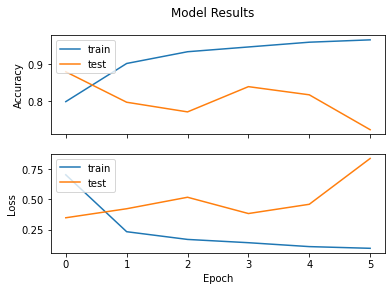

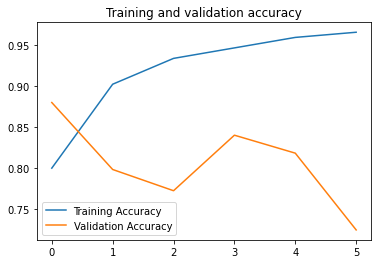

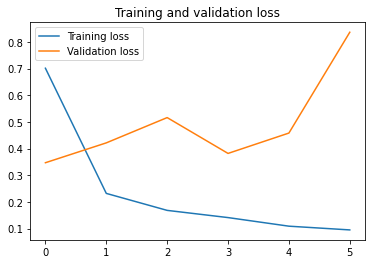

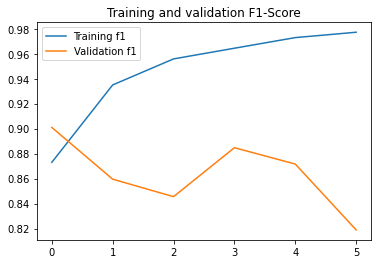

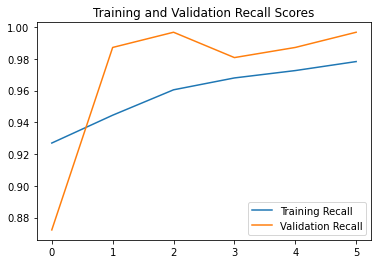

<Figure size 432x288 with 0 Axes>

In [49]:
score2 = model2.evaluate(X_val, y_val, verbose=2)
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])
print("Test recall:", score2[2])
print("Test precision:", score2[3])

visualize_training_results(history2)
plot_performance(history2)


## Evaluation

Our second model saw an overall accuracy increase from 84% to 88%. This is due largely to our improvemets in precision-accuractely identifying normal cases. Our recall score did go down slightly from 90% to 87%, but overall our model is performing better at all types of classification.

### Model 3 & 4

In creating this model, we dropped MaxPooling to see what effect it was having on our model. We also added a dropout layer to continue addressing overfitting that we see in our models. 

In [23]:
model3 = Sequential(
    [
        
        Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (255,255,3)),
        Flatten(), 
        Dense(64,activation="relu"),
        Dropout(.2),
        Dense(1, activation="sigmoid"), 
        
    ])


model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)


model3.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 32)      896       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2080800)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                133171264 
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 133,172,225
Trainable params: 133,172,225
Non-trainable params: 0
_________________________________________________________________


We allowed our model to run for 5 epochs to get a general idea of the performance over a small amount of time. An early stop was also implemented.

In [24]:
start = timer()

history3 = model3.fit(train_images,
                    train_labels,
                    epochs=5, 
                    validation_data =(X_val,y_val),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
163/163 [==============================] - 189s 1s/step - loss: 1.2650 - accuracy: 0.7130 - recall: 0.8963 - precision: 0.7603 - val_loss: 0.5420 - val_accuracy: 0.6680 - val_recall: 1.0000 - val_precision: 0.6534
Epoch 2/5
163/163 [==============================] - 190s 1s/step - loss: 0.4197 - accuracy: 0.7924 - recall: 0.8601 - precision: 0.8604 - val_loss: 0.4079 - val_accuracy: 0.7980 - val_recall: 0.9808 - val_precision: 0.7637
Epoch 3/5
163/163 [==============================] - 190s 1s/step - loss: 0.3117 - accuracy: 0.8625 - recall: 0.9203 - precision: 0.8973 - val_loss: 0.3458 - val_accuracy: 0.8660 - val_recall: 0.9457 - val_precision: 0.8555
Epoch 4/5
163/163 [==============================] - 190s 1s/step - loss: 0.2882 - accuracy: 0.8844 - recall: 0.9427 - precision: 0.9056 - val_loss: 0.3629 - val_accuracy: 0.8320 - val_recall: 0.9649 - val_precision: 0.8053
Epoch 5/5
163/163 [==============================] - 190s 1s/step - loss: 0.2685 - accuracy: 0.8930 - re

16/16 [==============================] - 2s 115ms/step - loss: 0.5315 - accuracy: 0.7660 - recall: 0.9840 - precision: 0.7333
Test loss: 0.5315291881561279
Test accuracy: 0.765999972820282
Test recall: 0.9840255379676819
Test precision: 0.7333333492279053


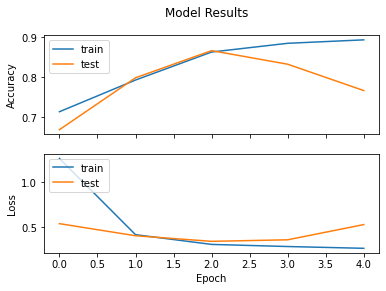

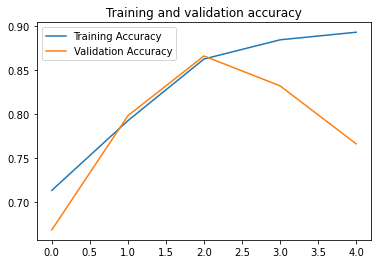

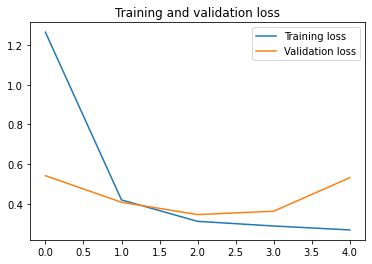

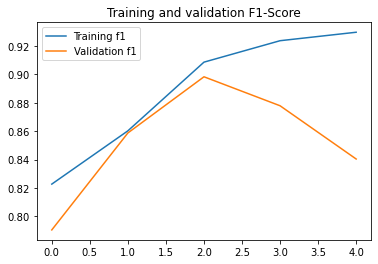

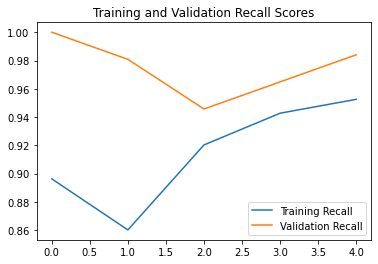

<Figure size 432x288 with 0 Axes>

In [25]:
score = model3.evaluate(X_val, y_val, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test recall:", score[2])
print("Test precision:", score[3])

visualize_training_results(history3)
plot_performance(history3)


With this model running for only 5 epochs, we are seeing a nice upward trend in accuracy, and a nice downward trend in loss. This indicate we should try letting our model run for a bit longer. We will bump our epochs up to 50 to see if we can make some improvements. 

In [26]:
start = timer()

history4 = model3.fit(train_images,
                    train_labels,
                    epochs=50, 
                    validation_data =(X_val,y_val),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/50
163/163 [==============================] - 191s 1s/step - loss: 0.2531 - accuracy: 0.8988 - recall: 0.9577 - precision: 0.9107 - val_loss: 0.5385 - val_accuracy: 0.7760 - val_recall: 0.9808 - val_precision: 0.7433
Epoch 2/50
163/163 [==============================] - 192s 1s/step - loss: 0.2540 - accuracy: 0.9007 - recall: 0.9639 - precision: 0.9081 - val_loss: 0.6964 - val_accuracy: 0.7280 - val_recall: 0.9904 - val_precision: 0.6998
Epoch 3/50
163/163 [==============================] - 191s 1s/step - loss: 0.2391 - accuracy: 0.9039 - recall: 0.9636 - precision: 0.9121 - val_loss: 0.5685 - val_accuracy: 0.7800 - val_recall: 0.9840 - val_precision: 0.7458
Epoch 4/50
163/163 [==============================] - 189s 1s/step - loss: 0.2452 - accuracy: 0.9062 - recall: 0.9639 - precision: 0.9145 - val_loss: 0.8098 - val_accuracy: 0.7180 - val_recall: 0.9904 - val_precision: 0.6920
Epoch 5/50
163/163 [==============================] - 190s 1s/step - loss: 0.2302 - accuracy: 0.9132

16/16 [==============================] - 2s 114ms/step - loss: 0.4279 - accuracy: 0.8220 - recall: 0.9744 - precision: 0.7902
Test loss: 0.4278695583343506
Test accuracy: 0.8220000267028809
Test recall: 0.97444087266922
Test precision: 0.7901554107666016


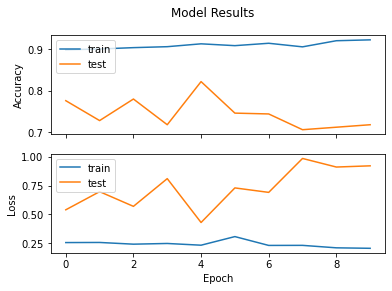

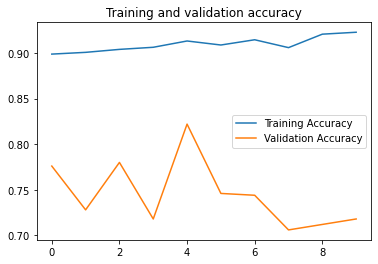

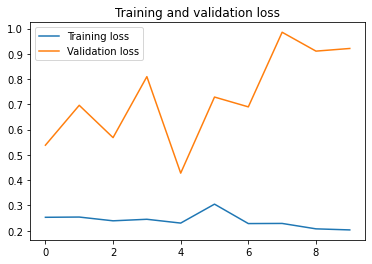

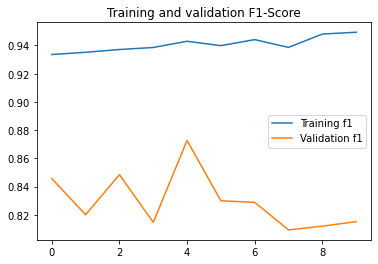

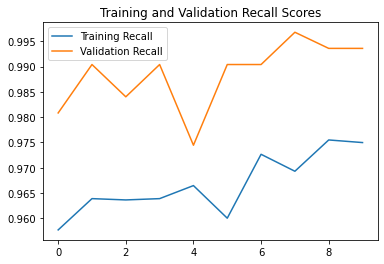

<Figure size 432x288 with 0 Axes>

In [27]:
score = model3.evaluate(X_val, y_val, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test recall:", score[2])
print("Test precision:", score[3])

visualize_training_results(history4)
plot_performance(history4)


### Evaluation

After allowing our model to run for longer, we did find improvements. Early stopping finalized learning after 10 epochs. We now see an accuracy of 82%, recall of 97%, and precision of 79%. While these scores are better than our initial model and our recall is very high, we do see a loss in precision. While recall is our most important metric, seeing this large of a loss in overall function would make our model less desirable to use. 

### Model 5

Our model 2 showed us that our AveragePooling2D layer was increasing our scores in our model. We decided to see if adding two Conv2D layers and two AveragePooling2D layers would also increase model function. We added another dense layer and kept a dropout layer to address overfitting.  

In [28]:
model_5 = Sequential(
    [
        
        Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (255,255,3)),
        AveragePooling2D(),
        Conv2D(32, 3, activation = 'relu', padding = 'same'),
        AveragePooling2D(),
        Flatten(), # need to flatten our images to be one long array
        Dense(120,activation="relu"),
        Dense(64,activation="relu"),
        Dropout(.2),
        Dense(1, activation="sigmoid"), 
        
    ])

model_5.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)


model_5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 255, 255, 32)      896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 127, 32)      9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               15241080  
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

When fitting this model, we decided to let it run for a longer period of time to evaluate model performance, but our early stop kept it from moving past 6 epochs.  

In [29]:
start = timer()

history_5 = model_5.fit(train_images,
                    train_labels,
                    epochs=50, 
                    validation_data =(X_val,y_val),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/50
163/163 [==============================] - 110s 675ms/step - loss: 0.3764 - accuracy: 0.8336 - recall: 0.9437 - precision: 0.8491 - val_loss: 0.3594 - val_accuracy: 0.8280 - val_recall: 0.9617 - val_precision: 0.8027
Epoch 2/50
163/163 [==============================] - 110s 672ms/step - loss: 0.1985 - accuracy: 0.9210 - recall: 0.9556 - precision: 0.9391 - val_loss: 0.5317 - val_accuracy: 0.7700 - val_recall: 0.9872 - val_precision: 0.7357
Epoch 3/50
163/163 [==============================] - 110s 673ms/step - loss: 0.1384 - accuracy: 0.9515 - recall: 0.9708 - precision: 0.9641 - val_loss: 0.7307 - val_accuracy: 0.7440 - val_recall: 0.9904 - val_precision: 0.7126
Epoch 4/50
163/163 [==============================] - 111s 678ms/step - loss: 0.1041 - accuracy: 0.9626 - recall: 0.9768 - precision: 0.9730 - val_loss: 1.1731 - val_accuracy: 0.7000 - val_recall: 0.9968 - val_precision: 0.6768
Epoch 5/50
163/163 [==============================] - 110s 677ms/step - loss: 0.0873 - a

16/16 [==============================] - 2s 138ms/step - loss: 0.3594 - accuracy: 0.8280 - recall: 0.9617 - precision: 0.8027
Test loss: 0.359430193901062
Test accuracy: 0.828000009059906
Test recall: 0.9616613388061523
Test precision: 0.8026666641235352


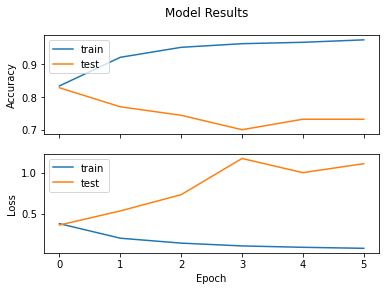

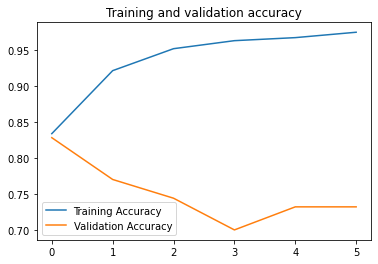

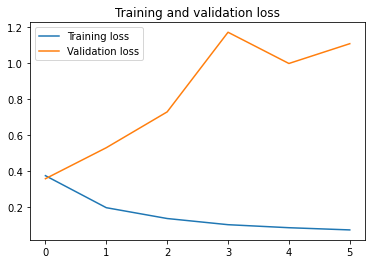

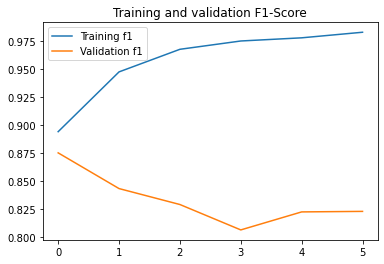

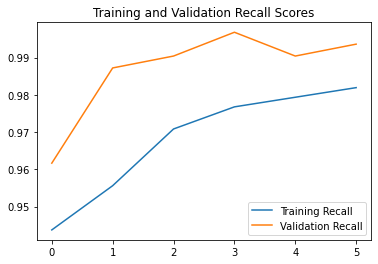

<Figure size 432x288 with 0 Axes>

In [30]:
score = model_5.evaluate(X_val, y_val, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test recall:", score[2])
print("Test precision:", score[3])

visualize_training_results(history_5)
plot_performance(history_5)


### Evaluation

In this model we saw our accuracy score move to 83%, recall 96%, and precision 80%. Our recall score is very good but there is still an issue with classifying our normal images. Ideally, we would like our final model to have a more even performance.

## Model 6 

In model 6, we wanted to see if increasing the dropout percentage in our dropout layer would help with our large overfitting issue in the previous model. We increased the dropout percentage to 50%.

In [31]:
model_6 = Sequential(
    [
        
        Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (255,255,3)),
        AveragePooling2D(),
        Conv2D(32, 3, activation = 'relu', padding = 'same'),
        AveragePooling2D(),
        Flatten(), # need to flatten our images to be one long array
        Dense(120,activation="relu"),
        Dense(64,activation="relu"),
        Dropout(.5),
        Dense(1, activation="sigmoid"), 
        
    ])

model_6.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])




model_6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 255, 255, 32)      896       
_________________________________________________________________
average_pooling2d_2 (Average (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 127, 127, 32)      9248      
_________________________________________________________________
average_pooling2d_3 (Average (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               15241080  
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

We set our epochs to 100 to give plenty of time for our model to train and improve.

In [32]:
start = timer()

history_6 = model_6.fit(train_images,
                    train_labels,
                    epochs=100, 
                    validation_data =(X_val,y_val),
                    callbacks = [cp],    
                    workers = 7, 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
163/163 [==============================] - 110s 677ms/step - loss: 0.4442 - accuracy: 0.7908 - recall: 0.9481 - precision: 0.8050 - val_loss: 0.4123 - val_accuracy: 0.8020 - val_recall: 0.9776 - val_precision: 0.7688
Epoch 2/100
163/163 [==============================] - 110s 674ms/step - loss: 0.2607 - accuracy: 0.8967 - recall: 0.9515 - precision: 0.9131 - val_loss: 0.4822 - val_accuracy: 0.7760 - val_recall: 0.9936 - val_precision: 0.7387
Epoch 3/100
163/163 [==============================] - 110s 674ms/step - loss: 0.1957 - accuracy: 0.9254 - recall: 0.9548 - precision: 0.9453 - val_loss: 0.8955 - val_accuracy: 0.6900 - val_recall: 0.9968 - val_precision: 0.6695
Epoch 4/100
163/163 [==============================] - 110s 674ms/step - loss: 0.1545 - accuracy: 0.9452 - recall: 0.9644 - precision: 0.9619 - val_loss: 0.8280 - val_accuracy: 0.7360 - val_recall: 0.9968 - val_precision: 0.7043
Epoch 5/100
163/163 [==============================] - 110s 673ms/step - loss: 0.121

Epoch 37/100
163/163 [==============================] - 110s 673ms/step - loss: 0.0027 - accuracy: 0.9990 - recall: 0.9995 - precision: 0.9992 - val_loss: 2.9460 - val_accuracy: 0.7300 - val_recall: 0.9968 - val_precision: 0.6996
Epoch 38/100
163/163 [==============================] - 110s 672ms/step - loss: 0.0055 - accuracy: 0.9981 - recall: 0.9995 - precision: 0.9979 - val_loss: 2.2938 - val_accuracy: 0.7600 - val_recall: 0.9968 - val_precision: 0.7239
Epoch 39/100
163/163 [==============================] - 110s 676ms/step - loss: 0.0032 - accuracy: 0.9994 - recall: 1.0000 - precision: 0.9992 - val_loss: 2.7963 - val_accuracy: 0.7500 - val_recall: 0.9936 - val_precision: 0.7166
Epoch 40/100
163/163 [==============================] - 111s 678ms/step - loss: 0.0065 - accuracy: 0.9981 - recall: 0.9992 - precision: 0.9982 - val_loss: 3.4667 - val_accuracy: 0.6740 - val_recall: 1.0000 - val_precision: 0.6576
Epoch 41/100
163/163 [==============================] - 110s 672ms/step - loss: 

16/16 [==============================] - 2s 135ms/step - loss: 5.1071 - accuracy: 0.7680 - recall: 0.9936 - precision: 0.7318
Test loss: 5.107147693634033
Test accuracy: 0.7680000066757202


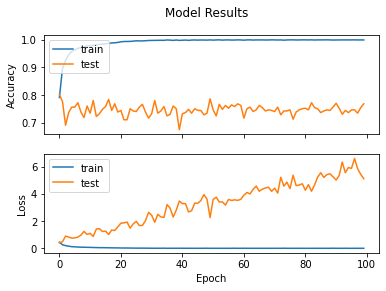

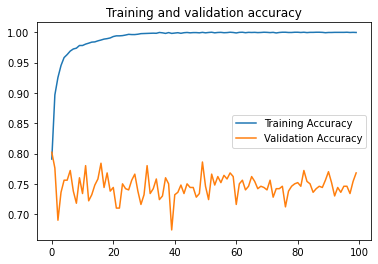

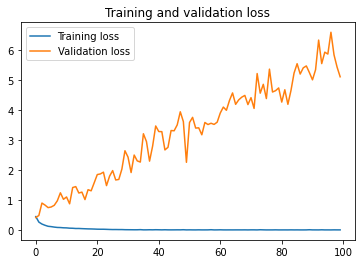

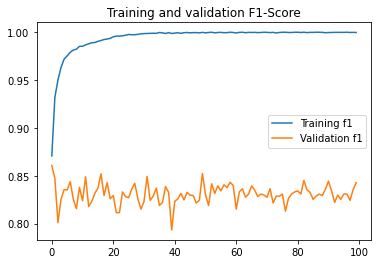

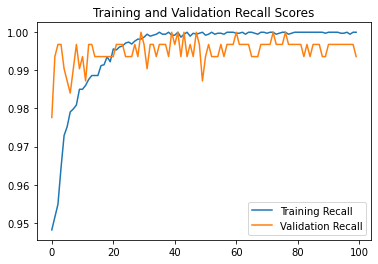

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

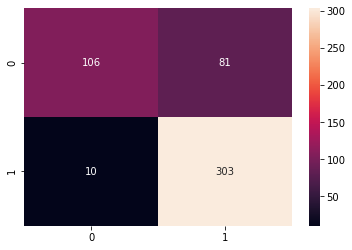

In [33]:
score = model_6.evaluate(X_val, y_val, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

visualize_training_results(history_6)
plot_performance(history_6)
matrix_confusion(model_6, X_val, y_val)

### Evaluation

This model gave us a recall score of 97%, but our accuracy and precision suffered. Our precision score was 79% and our overall accuracy dipped to 82%. 

# Final Model

In choosing our final model, we struggled between model 2 and model 5. Model 2 proved to be very consistent in all metrics but the recall score was not as high as it is in other models. We evenually decided to move forward with model 5 because it did not make as many mistakes classifying pneumonia patients. At the end of the day, ensuring patients with pneumonia are recognized early is of utmost importance to our stakeholders. 

In [62]:
score_final = model_5.evaluate(X_final_test, y_final_test, verbose=1)
print("Test loss:", score_final[0])
print("Test accuracy:", score_final[1])
print("Test recall:", score_final[2])
print("Test precision:", score_final[3])



4/4 [==============================] - 0s 118ms/step - loss: 0.4059 - accuracy: 0.7823 - recall: 1.0000 - precision: 0.7404
Test loss: 0.40588322281837463
Test accuracy: 0.7822580933570862
Test recall: 1.0
Test precision: 0.7403846383094788


Our final evaluation of our holdout images shows that every single pneumonia patient was classified accurately. The precision and overall accuracy is lower than in some of our models, but our recall shows we are correctly classifying patients who have pneumonia. 

### Final Model Image Insights

We want to take a look at the images our model is classifying thoughout our dataset and what it's getting right and wrong. 

In [59]:
preds = model_5.predict(test_images, verbose = 1)

20/20 [==============================] - 14s 678ms/step


In [36]:
test = test_generator

test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 255, 255, 3)
(624,)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


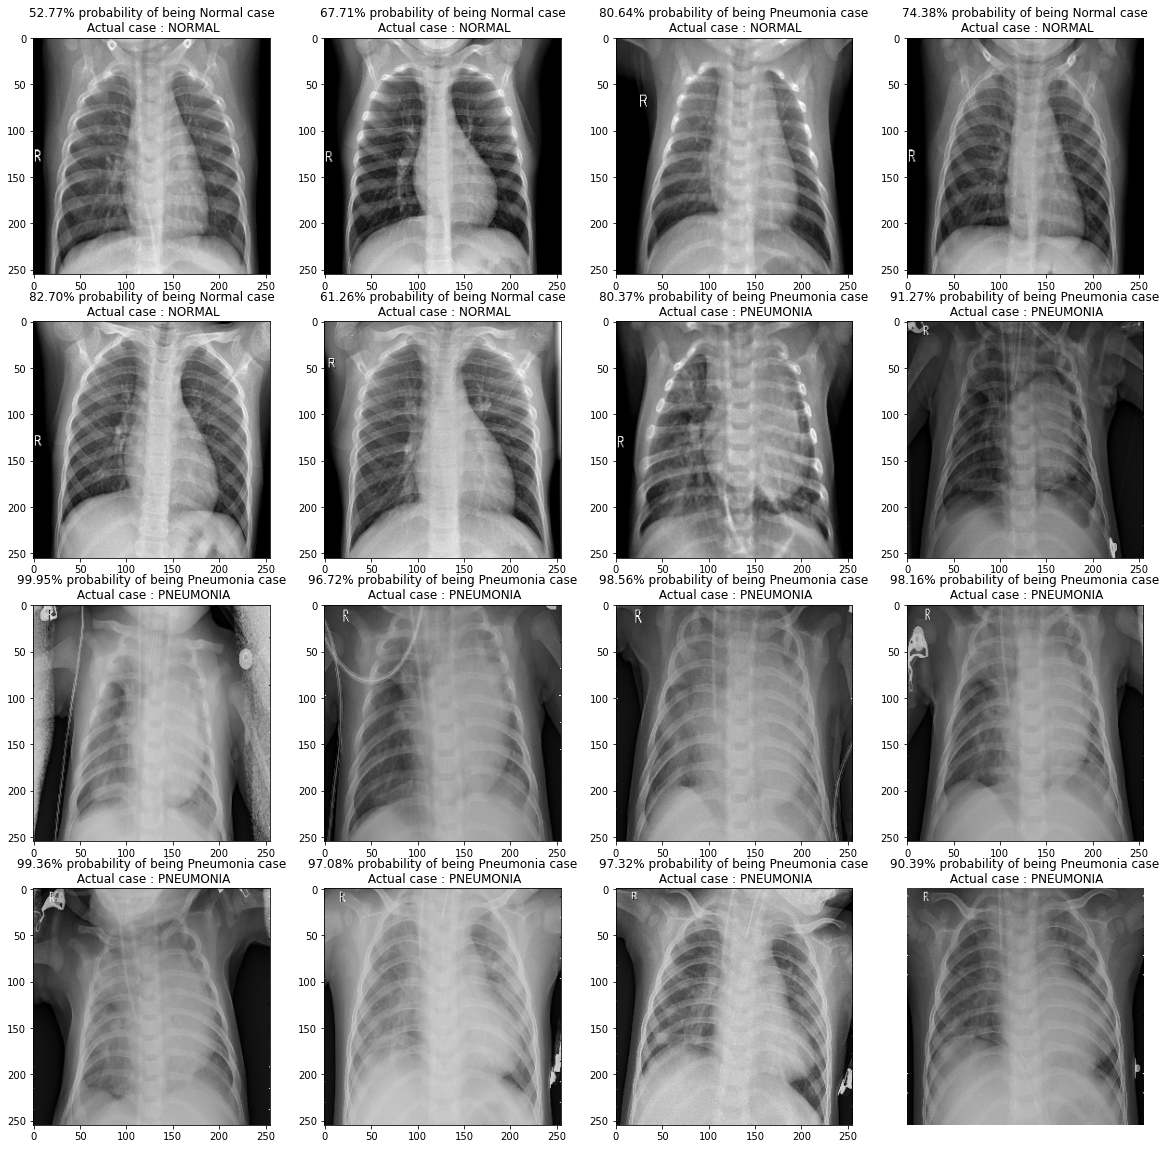

In [60]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
plot_model(model_5,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 16+228):
    
    plt.subplot(4, 4, (i-228)+1)
    if preds[i, 0] >= 0.5: 
        out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
    else: 
        out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
    plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
    plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()

### Conclusion


A CNN was created that correctly identified x-ray images as having pneumonia 100% of the time and identified Normal images 74% of the time with an overall accuracy of 78%. 

### Next Steps

We would like to make improvements in our current model by addressing the imbalance between normal and pneumonia images. The model trained very well on pneumonia images but the lack of normal images is holding our model back. 

We would like to make a tool that deploys our model easily for common use, either on a website or an aplplication. 

In future work, we would like to create a model that would be able to identify the type of pneumonia (viral/bacterial) present in the patient as treatments for the two types vary. Additionally, we would like to create a similar model using audio recordings of an individual’s breathing to identify the same pneumonia. In areas with low access to medical resources, many doctors detect pneumonia by listening to a patients breathing. Making this model would extend the potential reach and impact of our work by enabling individuals with no access to x-ray technology to be diagnosed as well. We would also like to perform an air quality survery to pinpoint areas with low air quality that could be increasing the risk of pneumonia in children. 